In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import scipy as sp

import pytry

In [5]:
from sklearn.decomposition import PCA


class PatternInterpolationTrial(pytry.Trial):
    def params(self):
        self.param('number of neurons', n_neurons=2000)
        
    def evaluate(self, p):
        data = pd.read_csv("pinsoro-2017-06-12-140651300755-small.csv", low_memory=False)

        x = np.array(data.iloc[:,11:195]).astype(float)
        a = []
        for i in range(x.shape[1]):
            y = pd.Series(x[:,i])
            z = y.interpolate(limit_direction='both')
            a.append(z)
        a = pd.DataFrame(a)
        a = a.dropna()
        a = np.array(a).T


        dt = 0.001

        def extract_pattern(start, end):
            pattern = np.array(a[start:end,:]).astype(float)
            frames = np.array(data.iloc[start:end,9]).astype(int)

            good_indices = frames != -1
            frames = frames[good_indices]
            pattern = pattern[good_indices]

            fps = 30.0
            t_sample = (frames - frames[0])/fps

            t = np.arange(int(t_sample[-1]/dt))*dt

            result = []
            for i in range(pattern.shape[1]):       
                p = np.interp(t, t_sample, pattern[:,i])
                result.append(p)
            result = np.array(result).T

            return t, result


        t1, result1 = extract_pattern(10175, 10280) #goaloriented
        t2, result2 = extract_pattern(22854, 23059) #noplay
        t3, result3 = extract_pattern(13811, 14182) #goaloriented
        t4, result4 = extract_pattern(9796, 10174) #noplay 
        t5, result5 = extract_pattern(22753, 22853) #goaloriented 
        t6, result6 = extract_pattern(14583, 14991) #noplay

        nb_components=1
        train_all = np.vstack([result1, result2, result3, result4, result5, result6])
        pca_model = PCA(n_components=nb_components).fit(train_all)
        #print("Cumulative explained variance: %s" % pca_model.explained_variance_ratio_.cumsum())

        p1 = pca_model.transform(result1)[:,0]
        p2 = pca_model.transform(result2)[:,0]
        p3 = pca_model.transform(result3)[:,0]
        p4 = pca_model.transform(result4)[:,0]
        p5 = pca_model.transform(result5)[:,0]
        p6 = pca_model.transform(result6)[:,0]

        #plt.plot(t1, p1, label='p1')
        #plt.plot(t2, p2, label='p2')
        #plt.plot(t3, p3, label='p3')
        #plt.plot(t4, p4, label='p4')
        #plt.plot(t5, p5, label='p5')
        #plt.plot(t6, p6, label='p6')
        #plt.legend()

        theta = 1.0

        net = nengo.Network()
        with net:
            process = nengo.processes.WhiteSignal(period=100., high=1.0, y0=0)
            rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=p.n_neurons, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))

        s_window = int(theta/dt)
        #print(s_window)
        s_pattern = min(len(p1), len(p2), len(p3), len(p4), len(p5), len(p6))

        t_window = np.linspace(0, 1, s_window)
        inv_basis = rw.inverse_basis(t_window)

        eval_points=[]
        target = []
        for i in range(s_pattern):
            eval_points.append(np.dot(inv_basis, np.roll(p1, i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(p2, i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(p3, i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(p4, i)[:s_window]))
            target.append([-1])
            eval_points.append(np.dot(inv_basis, np.roll(p5, i)[:s_window]))
            target.append([1])
            eval_points.append(np.dot(inv_basis, np.roll(p6, i)[:s_window]))
            target.append([-1])

        eval_points = np.array(eval_points)
        #print(eval_points.shape)

        with net:
            result = nengo.Node(None, size_in=1)
            nengo.Connection(rw.state, result,
                             eval_points=eval_points, scale_eval_points=True,
                             function=target, synapse=0.1)

        
        p_all = np.hstack([p1, p2, p3, p4, p5, p6])

        presentation_time_train=0.00063

        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_train))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

        #plt.plot(sim.trange(), sim.data[p_stim], label='input')
        #plt.plot(sim.trange(), sim.data[p_result], label='output')
        #plt.legend(loc='best')



        p1_len = int(len(p1)*presentation_time_train/dt)
        p2_len = p1_len+int(len(p2)*presentation_time_train/dt)
        p3_len = p2_len+int(len(p3)*presentation_time_train/dt)
        p4_len = p3_len+int(len(p4)*presentation_time_train/dt)
        p5_len = p4_len+int(len(p5)*presentation_time_train/dt)
        p6_len = p5_len+int(len(p6)*presentation_time_train/dt)

        mean1 = np.mean(sim.data[p_result][0:p1_len])
        std1 = np.std(sim.data[p_result][0:p1_len])
        median1 = np.median(sim.data[p_result][0:p1_len])
        mean2 = np.mean(sim.data[p_result][p1_len:p2_len])
        std2 = np.std(sim.data[p_result][p1_len:p2_len])
        median2 = np.median(sim.data[p_result][p1_len:p2_len])
        mean3 = np.mean(sim.data[p_result][p2_len:p3_len])
        std3 = np.std(sim.data[p_result][p2_len:p3_len])
        median3 = np.median(sim.data[p_result][p2_len:p3_len])
        mean4 = np.mean(sim.data[p_result][p3_len:p4_len])
        std4 = np.std(sim.data[p_result][p3_len:p4_len])
        median4 = np.median(sim.data[p_result][p3_len:p4_len])
        mean5 = np.mean(sim.data[p_result][p4_len:p5_len])
        std5 = np.std(sim.data[p_result][p4_len:p5_len])
        median5 = np.median(sim.data[p_result][p4_len:p5_len])
        mean6 = np.mean(sim.data[p_result][p5_len:p6_len])
        std6 = np.std(sim.data[p_result][p5_len:p6_len])
        median6 = np.median(sim.data[p_result][p5_len:p6_len])

        #print("Goal Oriented Mean:   ",mean1," SD: ",std1," Median: ",median1)
        #print("No Play Mean:         ",mean2," SD: ",std2," Median: ",median2)
        #print("Goal Oriented Mean:   ",mean3," SD: ",std3," Median: ",median3)
        #print("No Play Mean:         ",mean4," SD: ",std4," Median: ",median4)
        #print("Goal Oriented Mean:   ",mean5," SD: ",std5," Median: ",median5)
        #print("No Play Mean:         ",mean6," SD: ",std6," Median: ",median6)


        t7, result7 = extract_pattern(8684, 8990) #aimless
        t8, result8 = extract_pattern(10464, 10822) #aimless
        t9, result9 = extract_pattern(13062, 13810) #aimless

        testp1 = pca_model.transform(result7)[:,0]
        testp2 = pca_model.transform(result8)[:,0]
        testp3 = pca_model.transform(result9)[:,0]

        #plt.plot(t7, testp1, label='testp1')
        #plt.plot(t8, testp2, label='testp2')
        #plt.plot(t9, testp3, label='testp3')

        #plt.legend()
        

        testp = testp2
        p_all = np.hstack([p1, testp, p4])

        presentation_time_test=0.0011

        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

        #plt.plot(sim.trange(), sim.data[p_stim], label='input')
        #plt.plot(sim.trange(), sim.data[p_result], label='output')
        #plt.legend(loc='best')



        p1_len = int(len(p1)*presentation_time_test/dt)
        testp_len = p1_len+int(len(testp)*presentation_time_test/dt)
        p4_len = testp_len+int(len(p4)*presentation_time_test/dt)

        mean1 = np.mean(sim.data[p_result][0:p1_len])
        std1 = np.std(sim.data[p_result][0:p1_len])
        median1 = np.median(sim.data[p_result][0:p1_len])

        mean2 = np.mean(sim.data[p_result][p1_len:testp_len])
        std2 = np.std(sim.data[p_result][p1_len:testp_len])
        median2 = np.median(sim.data[p_result][p1_len:testp_len])

        mean3 = np.mean(sim.data[p_result][testp_len:p4_len])
        std3 = np.std(sim.data[p_result][testp_len:p4_len])
        median3 = np.median(sim.data[p_result][testp_len:p4_len])

        #print("Goal Oriented Mean:   ",mean1," SD: ",std1," Median: ",median1)
        #print("Aimless Mean:         ",mean2," SD: ",std2," Median: ",median2)
        #print("No Play Mean:         ",mean3," SD: ",std3," Median: ",median3)
        
        
        return dict(
            mean_goal=mean1,
            std_goal=std1,
            median_goal=median1,
            mean_aimless=mean2,
            std_aimless=std2,
            median_aimless=median2,
            mean_noplay=mean3,
            std_noplay=std3,
            median_noplay=median3,
        )


In [6]:
PatternInterpolationTrial().run()

running PatternInterpolationTrial#20190122-103717-96cac3d4


c:\users\terry\py3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
mean_aimless = 0.4479469621066245
mean_goal = 0.5113293599712062
mean_noplay = -0.15836460138270975
median_aimless = 0.3896296066127606
median_goal = 0.5714383712925883
median_noplay = 0.029218707900557223
std_aimless = 0.9159157601030794
std_goal = 0.35866731418209286
std_noplay = 0.43037766282252377


{'mean_aimless': 0.4479469621066245,
 'mean_goal': 0.5113293599712062,
 'mean_noplay': -0.15836460138270975,
 'median_aimless': 0.3896296066127606,
 'median_goal': 0.5714383712925883,
 'median_noplay': 0.029218707900557223,
 'std_aimless': 0.9159157601030794,
 'std_goal': 0.35866731418209286,
 'std_noplay': 0.43037766282252377}

In [9]:
for seed in range(2):
    PatternInterpolationTrial().run(seed=seed, data_dir='basic_experiment')

running PatternInterpolationTrial#20190122-104155-de57966c


c:\users\terry\py3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
mean_aimless = 0.3970490313643537
mean_goal = 0.5201683994186217
mean_noplay = -0.12551287165668312
median_aimless = 0.5020341081793528
median_goal = 0.5897584615053131
median_noplay = 0.11345209860279531
std_aimless = 0.8946142890032165
std_goal = 0.3436169048729272
std_noplay = 0.501456950162044
running PatternInterpolationTrial#20190122-104303-a1bca411


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
mean_aimless = 0.4479469621066245
mean_goal = 0.5113293599712062
mean_noplay = -0.15836460138270972
median_aimless = 0.38962960661276047
median_goal = 0.5714383712925883
median_noplay = 0.02921870790055721
std_aimless = 0.9159157601030794
std_goal = 0.35866731418209286
std_noplay = 0.43037766282252377


In [8]:
print(PatternInterpolationTrial().show_params())

    n_neurons: number of neurons (default=2000)
         seed: random number seed (default=1)
     data_dir: data directory (default='data')
data_filename: filename for data (default='')
  data_format: data file format [txt,npz] (default='txt')
      verbose: print progress information (default=True)


In [4]:
for seed in range(2):
    for n_neurons in [200, 500, 1000, 2000, 5000]:
        PatternInterpolationTrial().run(seed=seed, n_neurons=n_neurons,
                                        data_dir='vary_n_neurons')

c:\users\terry\py3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [11]:
data = pytry.read('basic_experiment')

In [14]:
print(list(data))

[{'seed': 0, 'n_neurons': 2000, 'mean_goal': 0.5201683994186217, 'std_goal': 0.3436169048729272, 'median_goal': 0.5897584615053131, 'mean_aimless': 0.3970490313643537, 'std_aimless': 0.8946142890032165, 'median_aimless': 0.5020341081793528, 'mean_noplay': -0.12551287165668312, 'std_noplay': 0.501456950162044, 'median_noplay': 0.11345209860279531}, {'seed': 1, 'n_neurons': 2000, 'mean_goal': 0.5113293599712062, 'std_goal': 0.35866731418209286, 'median_goal': 0.5714383712925883, 'mean_aimless': 0.4479469621066245, 'std_aimless': 0.9159157601030794, 'median_aimless': 0.38962960661276047, 'mean_noplay': -0.15836460138270972, 'std_noplay': 0.43037766282252377, 'median_noplay': 0.02921870790055721}]


In [17]:
import pandas
df = pandas.DataFrame(pytry.read('basic_experiment'))

In [18]:
df

,mean_aimless,mean_goal,mean_noplay,median_aimless,median_goal,median_noplay,n_neurons,seed,std_aimless,std_goal,std_noplay
0,0.397049,0.520168,-0.125513,0.502034,0.589758,0.113452,2000,0,0.894614,0.343617,0.501457
1,0.447947,0.511329,-0.158365,0.389630,0.571438,0.029219,2000,1,0.915916,0.358667,0.430378


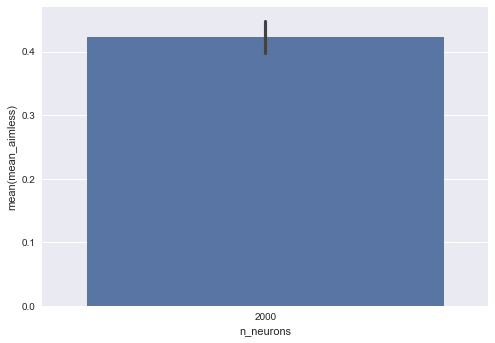

In [20]:
import seaborn

seaborn.barplot('n_neurons', 'mean_aimless', data=df)